# Boston House Prices prediction
Challenges from the dataset:

- Missing value treatment
- Outlier treatment
- Understanding which variables drive the price of homes in Boston


- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per 10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

Neste estudo, realizamos a observação e análise dos dados, incluindo a identificação e tratamento de outliers e valores nulos. Interpretamos as colunas, normalizamos os dados e removemos colunas irrelevantes. Além disso, analisamos as características mais importantes para a previsão, visando melhorar a precisão e eficácia do modelo preditivo.

Abordagens de outras pessoas (Kaggle)
- https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset
- https://www.kaggle.com/code/shreayan98c/boston-house-price-prediction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from xgboost import XGBRegressor
import tensorflow as tf

colunas = ['CRIM', 'ZN', 'CHAS', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('HousingData.csv')

In [2]:
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


## Funções para pré processamento

In [3]:
def exibeNa(data):
    print(data.isna().sum())

def substituiNaPorMediana(data):
    for coluna in colunas:
        mediana = data[coluna].median()
        data[coluna] = data[coluna].fillna(mediana)

def exibeBoxPlot(data, colunas, a, b):
    plt.figure(figsize=(a, b))
    data.boxplot(column=colunas)
    plt.show()

def exibeQntdOutliers(data):
    for k, v in data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

def removeOutiliers(data, colunas_outlier):
    for coluna in colunas_outlier:
        Q1 = data[coluna].quantile(0.25)
        Q3 = data[coluna].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (data[coluna] < lower_bound) | (data[coluna] > upper_bound)
        data.loc[outliers, coluna] = None

    data_cleaned = data.dropna(subset=colunas_outlier)
    return data_cleaned

def normalize_data(data, colunas):
    data_normalized = data.copy()

    min_max_scaler = MinMaxScaler()
    data_normalized[colunas] = min_max_scaler.fit_transform(data_normalized[colunas])

    return data_normalized

def checaBalanceamento(data, coluna):
    quantidade_zeros = (data[coluna] == 0).sum()
    total_valores_na_coluna = data[coluna].count()
    porcentagem_zeros = quantidade_zeros / total_valores_na_coluna * 100
    print("Porcentagem de zeros para {}: {:.2f}%".format(coluna, porcentagem_zeros))

def binarizar_coluna(data, coluna):
    data[coluna] = data[coluna].apply(lambda x: 1 if x != 0 else 0)
    return data

def calculaMetricasTreino(modelo, x_train, y_train):
  # Métricas de treino
  y_pred_train = modelo.predict(x_train)
  print('R^2 train:',metrics.r2_score(y_train, y_pred_train))
  print('MAE train:',metrics.mean_absolute_error(y_train, y_pred_train))
  print('MSE train:',metrics.mean_squared_error(y_train, y_pred_train))
  print('RMSE train:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
  return metrics.r2_score(y_train, y_pred_train), metrics.mean_absolute_error(y_train, y_pred_train)

def exibeGraficoPredXRealTreino(modelo, x_train, y_train):
  plt.figure(figsize=(7, 4))
  # Grafico de treino
  y_pred_train = modelo.predict(x_train)
  # Gráfico que mostra como o modelo se ajusta aos dados de treinamento. (overfitting)
  plt.scatter(y_train, y_pred_train)
  plt.xlabel("Prices")
  plt.ylabel("Predicted prices")
  plt.title("Como o modelo se ajusta aos dados de treinamento")
  plt.show()

def calculaMetricasTeste(modelo, x_test, y_test):
  # Métricas de teste
  y_pred = modelo.predict(x_test)
  print('R^2 test:',metrics.r2_score(y_test, y_pred))
  print('MAE test:',metrics.mean_absolute_error(y_test, y_pred))
  print('MSE test:',metrics.mean_squared_error(y_test, y_pred))
  print('RMSE test:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  return metrics.r2_score(y_test, y_pred), metrics.mean_absolute_error(y_test, y_pred)

def exibeGraficoPredXRealTeste(modelo, x_test, y_test):
  plt.figure(figsize=(7, 4))
  # Grafico de teste
  y_pred = modelo.predict(x_test)
  # Gráfico que mostra como o modelo se sai em dados que não foram vistos durante o treinamento.
  plt.scatter(y_test, y_pred)
  plt.xlabel("Prices")
  plt.ylabel("Predicted prices")
  plt.title("Como o modelo se sai em dados que não foram vistos durante o treinamento")
  plt.show()

def calculaMetricas(modelo, x_treino, x_teste, y_treino, y_teste):
  calculaMetricasTreino(modelo, x_treino, y_treino)
  exibeGraficoPredXRealTreino(modelo, x_treino, y_treino)

  calculaMetricasTeste(modelo, x_teste, y_teste)
  exibeGraficoPredXRealTeste(modelo, x_teste, y_teste)

def comparaMetricas(r2, mae, r2After, maeAfter, treinoOuTeste):

    # Nomes das métricas
    metricas = ['R²', 'MAE']

    # Valores das métricas antes e depois
    valores_antes = [r2, mae]
    valores_depois = [r2After, maeAfter]

    # Largura das barras
    largura_barra = 0.35

    # Posições das barras no eixo x
    x = range(len(metricas))

    # Criar a figura
    plt.figure(figsize=(7, 4))

    # Plotar as barras para os valores antes e depois
    plt.bar([p - largura_barra/2 for p in x], valores_antes, largura_barra, label='Antes')
    plt.bar([p + largura_barra/2 for p in x], valores_depois, largura_barra, label='Depois')

    # Adicionar título e rótulos aos eixos
    plt.title(treinoOuTeste)
    plt.xlabel('Métricas')
    plt.ylabel('Valores')
    plt.xticks(x, metricas)
    plt.legend()

    # Mostrar os valores nas barras
    for i in x:
        plt.text(i - largura_barra/2, valores_antes[i] + 0.01, f'{valores_antes[i]:.2f}', ha='center', va='bottom')
        plt.text(i + largura_barra/2, valores_depois[i] + 0.01, f'{valores_depois[i]:.2f}', ha='center', va='bottom')

    # Mostrar o gráfico
    plt.show()



## Criando dataset **df1** para análise

In [34]:
df1 = data.copy()
df1.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


As colunas ZN e CHAS não possuem definição nítida de intervalos interquartilicos, então talvez seja necessário um tratamento diferente dos outros dados:
- CHAS: Os dados dessa coluna se referem à proximidade da residência com o rio Charles. 1 se o rio corta, 0 caso contrário. Por isso a exibição binária.

- ZN: Os quartis (25%, 50% e 75%) e os valores mínimos e máximos sugerem uma distribuição assimétrica para a variável ZN. Isso sugere que a maioria dos terrenos residenciais pode ter uma proporção baixa ou nula de lotes acima de 25.000 pés quadrados, com alguns valores atingindo proporções mais altas.
Para facilitar o tratamento vamos binarizar ZN com a referencia em 25.000 pés quadrados.

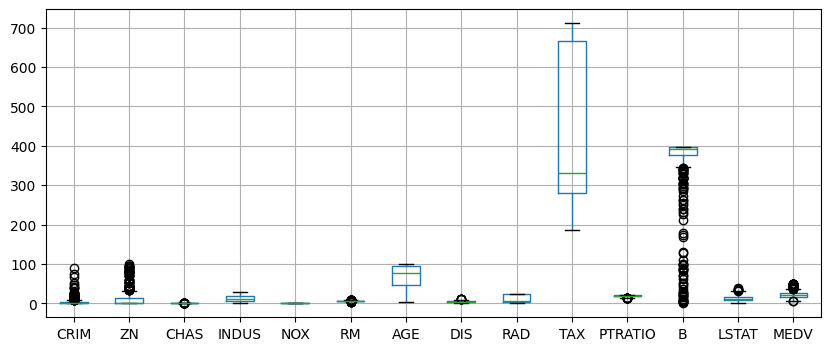

In [5]:
exibeBoxPlot(df1, colunas, 10, 4)

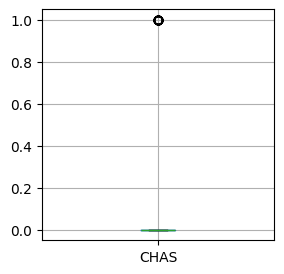

In [6]:
exibeBoxPlot(df1, 'CHAS', 3, 3)

No gráfico, os valores binários 1 são tratados como outliers, simplesmente por estarem em menor quantidade.

In [7]:
checaBalanceamento(df1, 'ZN')
checaBalanceamento(df1, 'CHAS')

Porcentagem de zeros para ZN: 74.07%
Porcentagem de zeros para CHAS: 93.00%


## Removendo CHAS
-Como CHAS está excessivamente desbalanceada, vamos remover essa coluna do nosso dataset.

In [8]:
df1 = df1.drop('CHAS', axis=1)
#atualizando colunas
colunas = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

## Binarizando dados de ZN

Caso seja necessário, podemos balancear ou remover essa coluna futuramente. Por enquanto, vamos mantê-la dessa forma.

In [33]:
binarizar_coluna(df1, 'ZN')
df1.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,506.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,0.288538,11.083992,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,0.453531,6.835896,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,1.000000,18.100000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,1.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Normalizando dados

In [10]:
colunasContinuas = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data_normalizado = normalize_data(df1, colunasContinuas)

In [35]:
data_normalizado.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.008188,0.288538,0.387423,0.349167,0.511451,0.679154,0.235380,0.371713,0.422208,0.642419,0.981081,0.287505,0.349104
std,0.015906,0.453531,0.245773,0.238431,0.099180,0.283079,0.180104,0.378576,0.321636,0.206141,0.026280,0.172048,0.137572
min,0.000000,0.000000,0.000000,0.000000,0.252730,0.000000,0.000000,0.000000,0.000000,0.106383,0.868904,0.000000,0.013333
25%,0.000865,0.000000,0.173387,0.131687,0.448122,0.443100,0.088259,0.130435,0.175573,0.510638,0.977848,0.151766,0.268889
50%,0.001941,0.000000,0.338343,0.314815,0.502491,0.761071,0.183934,0.173913,0.272901,0.691489,0.990796,0.267660,0.346667
75%,0.004551,1.000000,0.646628,0.491770,0.566057,0.933831,0.362195,1.000000,0.914122,0.808511,0.998298,0.396868,0.417778
max,0.076372,1.000000,1.000000,1.000000,0.791339,1.000000,0.735962,1.000000,1.000000,1.000000,1.000000,0.779249,0.700000


## Verificando e removendo valores nulos

In [12]:
exibeNa(data_normalizado)

CRIM       20
ZN          0
INDUS      20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


In [13]:
substituiNaPorMediana(data_normalizado)
exibeNa(data_normalizado)

CRIM       0
ZN         0
INDUS      0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


## Avaliando outliers
- Exibindo visualmente por boxplot
- Exibindo porcentagens de outliers por coluna

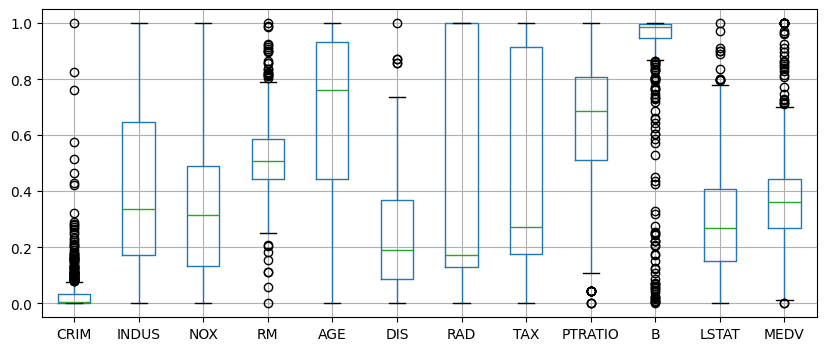

In [14]:
exibeBoxPlot(data_normalizado, colunasContinuas, 10, 4)

In [15]:
exibeQntdOutliers(data_normalizado)

Column CRIM outliers = 16.01%
Column ZN outliers = 0.00%
Column INDUS outliers = 0.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 2.37%
Column MEDV outliers = 7.91%


## Removendo outliers
- Definindo as colunas com quantidade significativa de outliers
- Removendo os outliers

In [16]:
colunas_outlier = ['CRIM', 'RM', 'PTRATIO', 'DIS', 'B', 'LSTAT', 'MEDV']
removeOutiliers(data_normalizado, colunas_outlier)
substituiNaPorMediana(data_normalizado)
#clean_outliers(data_normalizado, types = "IQR", threshold = 3.0)

In [17]:
exibeQntdOutliers(data_normalizado)

Column CRIM outliers = 17.39%
Column ZN outliers = 0.00%
Column INDUS outliers = 0.00%
Column NOX outliers = 0.00%
Column RM outliers = 2.96%
Column AGE outliers = 0.00%
Column DIS outliers = 0.00%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 0.00%
Column B outliers = 10.28%
Column LSTAT outliers = 0.99%
Column MEDV outliers = 3.75%


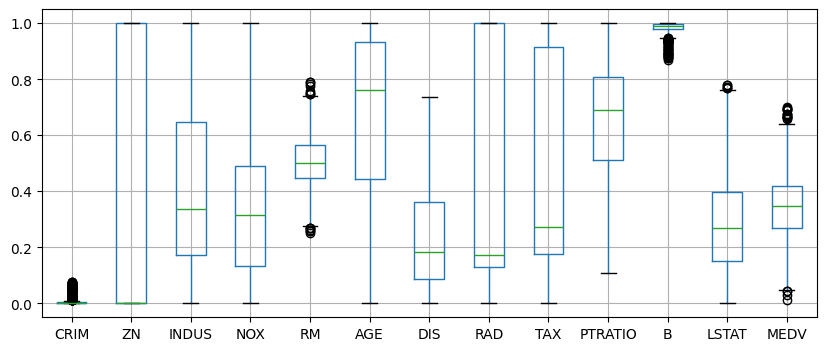

In [18]:
exibeBoxPlot(data_normalizado, colunas, 10, 4)

## Removendo CRIM e B
- Como as colunas CRIM e B possuiam um altíssimo numero de outliers, ao removê-los, observou-se um viés muito grande nessas variáveis, de forma que todos os valores de CRIM estavam muito próximos de zero e os de B estavam muito próximos de 1. Semelhante ao que aconteceu com CHAS.
- Por isso, removerei essas duas outras colunas

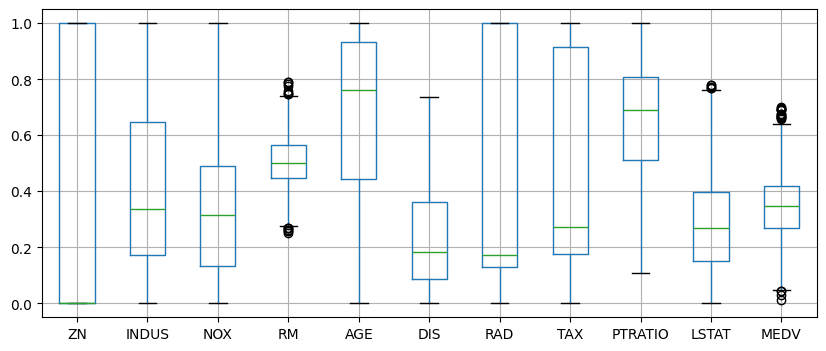

In [19]:
# Removendo do dataset
data_tratado = data_normalizado.drop(['CRIM', 'B'], axis=1)

# Atualizando colunas
colunas = ['ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV']

exibeBoxPlot(data_tratado, colunas, 10, 4)

# Dividindo dados de treino e teste

In [20]:
x = data_tratado.drop("MEDV", axis=1)
y = data_tratado["MEDV"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Modelo Gradient Boost

R^2 train: 0.9328745995505868
MAE train: 0.02747212631428233
MSE train: 0.0013062180177186673
RMSE train: 0.03614163828216241


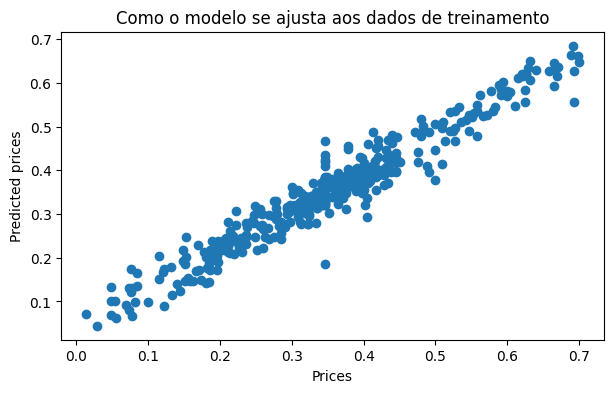

R^2 test: 0.7485025138149407
MAE test: 0.047148158471071275
MSE test: 0.004152920029911728
RMSE test: 0.06444315347584821


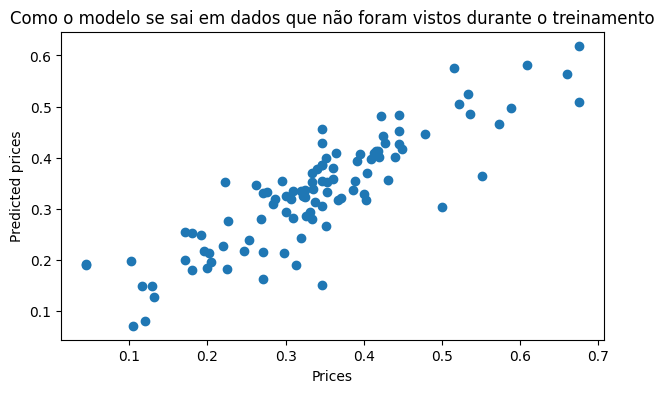

In [21]:
# Criando e treinando o modelo de Gradient Boosting
modelGB = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
modelGB.fit(x_train, y_train)

calculaMetricas(modelGB, x_train, x_test, y_train, y_test)

## Modelo de Rede Neural

In [22]:
# Criando o modelo de redes neurais
modelRN = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compilando o modelo
modelRN.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
modelRN.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

loss = modelRN.evaluate(x_test, y_test)

c:\Users\Diogo\Desktop\IA\teste\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1231 - val_loss: 0.0490
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0473 - val_loss: 0.0184
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0219 - val_loss: 0.0152
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - val_loss: 0.0143
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - val_loss: 0.0108
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_l

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R^2 train: 0.7286413936225724
MAE train: 0.053738860065697364
MSE train: 0.005280467580679024
RMSE train: 0.07266682586076692
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


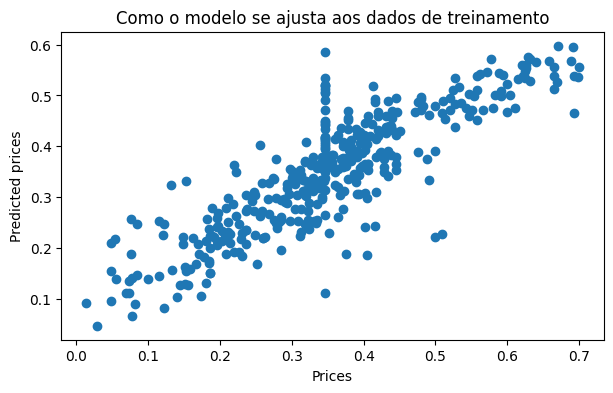

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
R^2 test: 0.662524491495261
MAE test: 0.05669718447139319
MSE test: 0.005572655298203277
RMSE test: 0.07465021967953797
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


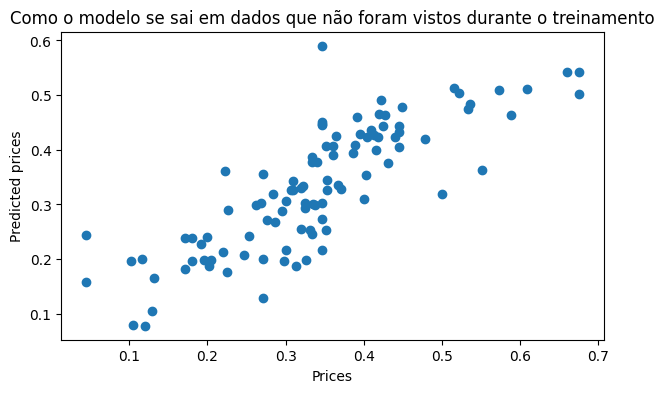

In [23]:
#calculando metricas do modelo de redes neurais
calculaMetricas(modelRN, x_train, x_test, y_train, y_test)

## Random Forest Regressor

R^2 train: 0.9578759901608056
MAE train: 0.020378272827282735
MSE train: 0.0008197067021146561
RMSE train: 0.028630520465312122


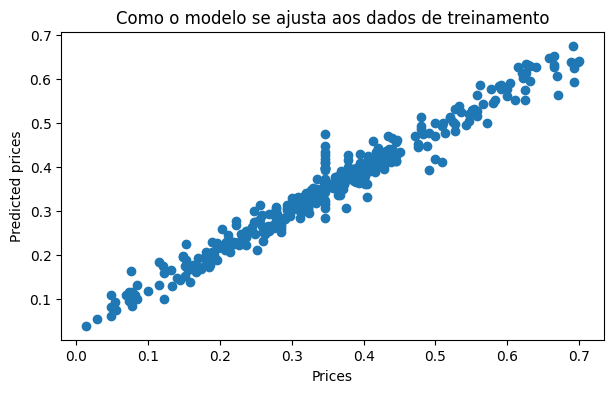

R^2 test: 0.7914166196138418
MAE test: 0.04447080610021786
MSE test: 0.003444289290728638
RMSE test: 0.0586880677031425


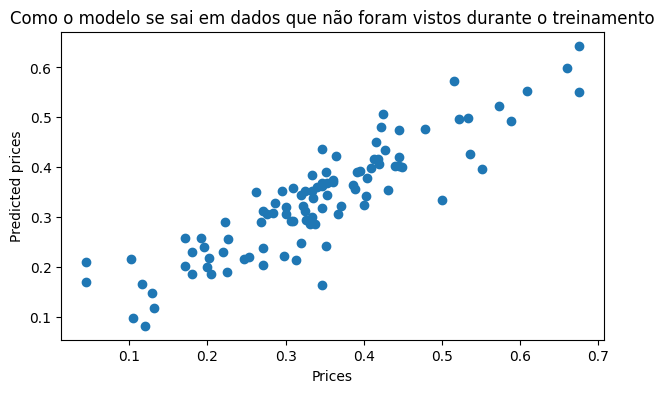

In [24]:
#Treinando o modelo
modelRF = RandomForestRegressor()
modelRF.fit(x_train, y_train)

#calculando metricas
calculaMetricas(modelRF, x_train, x_test, y_train, y_test)

## XGBoost Regression

R^2 train: 0.9999216192091283
MAE train: 0.000860036282141346
MSE train: 1.5252408267845762e-06
RMSE train: 0.0012350064075884694


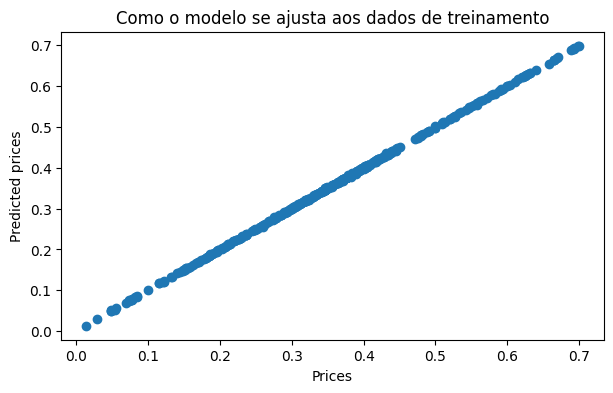

R^2 test: 0.763188689648179
MAE test: 0.04674168896587455
MSE test: 0.003910410592915676
RMSE test: 0.0625332758850492


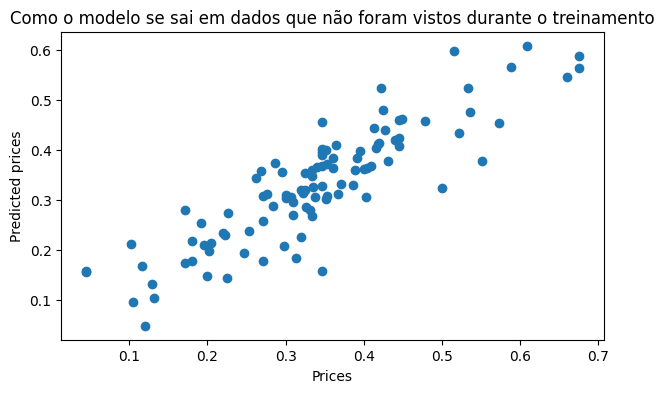

In [25]:
# Treinando o modelo
modelXG = XGBRegressor()
modelXG.fit(x_train, y_train)

calculaMetricas(modelXG, x_train, x_test, y_train, y_test)

## Comparando os modelos

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


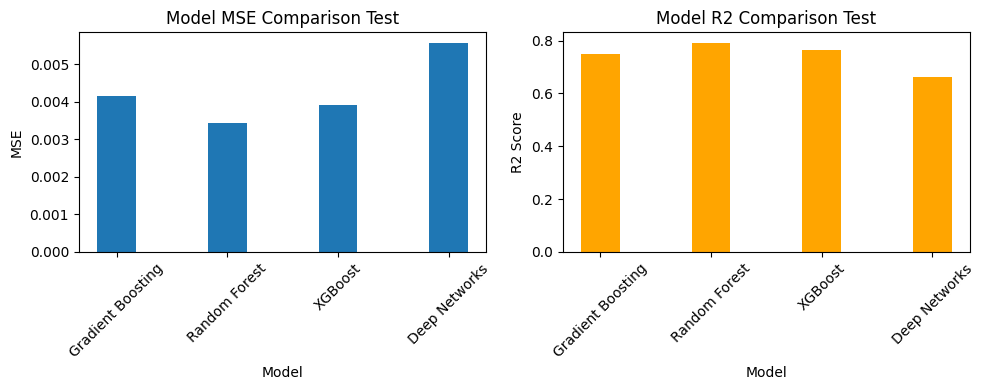

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


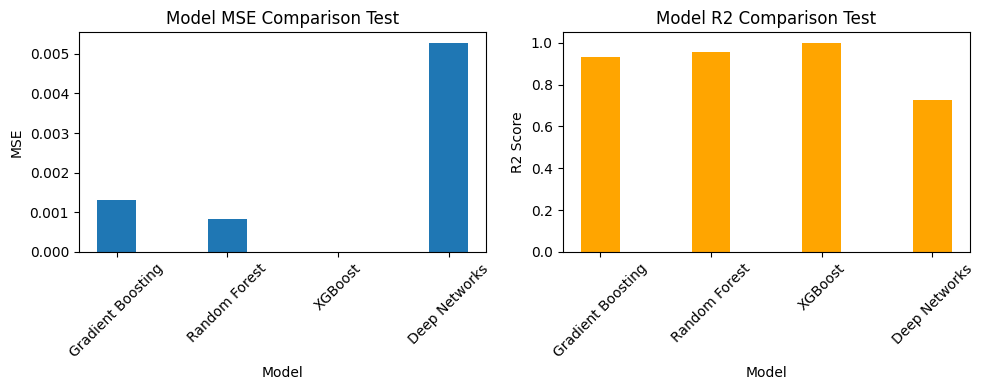

In [26]:
# Calculando as previsões para os modelos

#teste
y_predGB_test = modelGB.predict(x_test)
y_predRF_test = modelRF.predict(x_test)
y_predXG_test = modelXG.predict(x_test)
y_predRN_test = modelRN.predict(x_test)

# Calculando os erros MSE para cada modelo
errors_mse_test = [
    metrics.mean_squared_error(y_test, y_predGB_test),
    metrics.mean_squared_error(y_test, y_predRF_test),
    metrics.mean_squared_error(y_test, y_predXG_test),
    metrics.mean_squared_error(y_test, y_predRN_test)
]

# Calculando o R^2 para cada modelo
r2_scores_test = [
    metrics.r2_score(y_test, y_predGB_test),
    metrics.r2_score(y_test, y_predRF_test),
    metrics.r2_score(y_test, y_predXG_test),
    metrics.r2_score(y_test, y_predRN_test)
]

# Definindo os nomes dos modelos
model_names = ['Gradient Boosting', 'Random Forest', 'XGBoost', 'Deep Networks']  # Corrigido para corresponder aos modelos

# Criando os índices para as barras
bar_width = 0.35
index = np.arange(len(model_names))

# Plotando o gráfico de barras para o MSE
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(index, errors_mse_test, bar_width)
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model MSE Comparison Test')
plt.xticks(index, model_names, rotation=45)

# Plotando o gráfico de barras para o R^2
plt.subplot(1, 2, 2)
plt.bar(index, r2_scores_test, bar_width, color='orange')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model R2 Comparison Test')
plt.xticks(index, model_names, rotation=45)

plt.tight_layout()
plt.show()

#treino
y_predGB_train = modelGB.predict(x_train)
y_predRF_train = modelRF.predict(x_train)
y_predXG_train = modelXG.predict(x_train)
y_predRN_train = modelRN.predict(x_train)

# Calculando os erros MSE para cada modelo
errors_mse_train = [
    metrics.mean_squared_error(y_train, y_predGB_train),
    metrics.mean_squared_error(y_train, y_predRF_train),
    metrics.mean_squared_error(y_train, y_predXG_train),
    metrics.mean_squared_error(y_train, y_predRN_train)
]

# Calculando o R^2 para cada modelo
r2_scores_train = [
    metrics.r2_score(y_train, y_predGB_train),
    metrics.r2_score(y_train, y_predRF_train),
    metrics.r2_score(y_train, y_predXG_train),
    metrics.r2_score(y_train, y_predRN_train)
]

# Definindo os nomes dos modelos
model_names = ['Gradient Boosting', 'Random Forest', 'XGBoost', 'Deep Networks']  # Corrigido para corresponder aos modelos

# Criando os índices para as barras
bar_width = 0.35
index = np.arange(len(model_names))

# Plotando o gráfico de barras para o MSE
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(index, errors_mse_train, bar_width)
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model MSE Comparison Test')
plt.xticks(index, model_names, rotation=45)

# Plotando o gráfico de barras para o R^2
plt.subplot(1, 2, 2)
plt.bar(index, r2_scores_train, bar_width, color='orange')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model R2 Comparison Test')
plt.xticks(index, model_names, rotation=45)

plt.tight_layout()
plt.show()


# Análise das características mais importantes para previsão
- As correlações variam de -1 a 1. Será que variaveis com valores próximos de -1 ou de 1 em relação à variavel predita são melhores ou piores para previsão de um dado?

<Axes: >

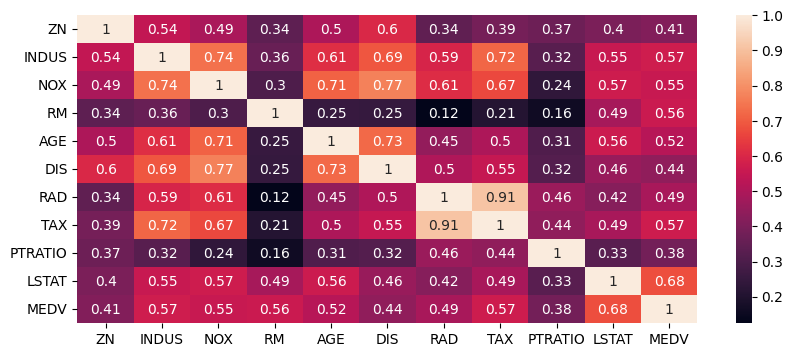

In [27]:
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.heatmap(data_tratado.corr().abs(),  annot=True)

Vamos selecionar LSTAT, TAX, AGE, RM, NOX, INDUS como colunas preditoras, já que são as variáveis que têm as correlações mais fortes e mais significativas com a variável alvo (próximas de -0.5 ou de 0.5). Para isso, removemos PTRATIO, DIS, ZN e RAD

In [28]:
data_tratado_importante = data_tratado.drop(columns=['PTRATIO', 'DIS', 'ZN', 'RAD'])

# Testando novo tratamento para o modelo de Random Forest

In [29]:
x = data_tratado_importante.drop("MEDV", axis=1)
y = data_tratado_importante["MEDV"]

x_trainAfter, x_testAfter, y_trainAfter, y_testAfter = train_test_split(x, y, test_size=0.2, random_state=42)

modeloRFdepois = RandomForestRegressor()
modeloRFdepois.fit(x_trainAfter, y_trainAfter)

RandomForestRegressor()

## Comparação das predições de teste

R^2 test: 0.7914166196138418
MAE test: 0.04447080610021786
MSE test: 0.003444289290728638
RMSE test: 0.0586880677031425
R^2 test: 0.7872616514667684
MAE test: 0.045279520697167765
MSE test: 0.0035128993221980164
RMSE test: 0.059269716737960006


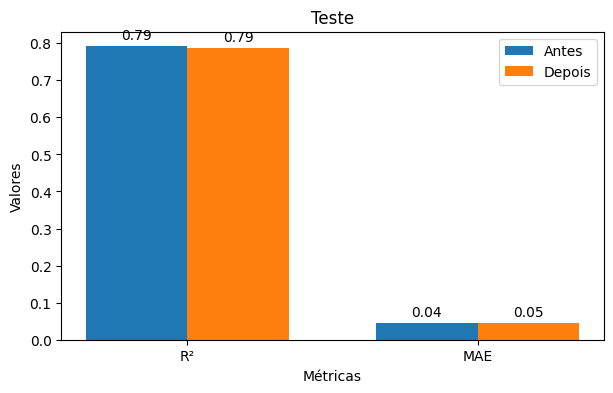

In [30]:
r2 , mae = calculaMetricasTeste(modelRF, x_test, y_test)
r2After , maeAfter = calculaMetricasTeste(modeloRFdepois, x_testAfter, y_testAfter)

comparaMetricas(r2, mae, r2After, maeAfter, "Teste")

## Comparação das predições de treino

R^2 train: 0.9578759901608056
MAE train: 0.020378272827282735
MSE train: 0.0008197067021146561
RMSE train: 0.028630520465312122
R^2 train: 0.9591147681316011
MAE train: 0.02052519251925193
MSE train: 0.0007956008629751863
RMSE train: 0.02820639755401576


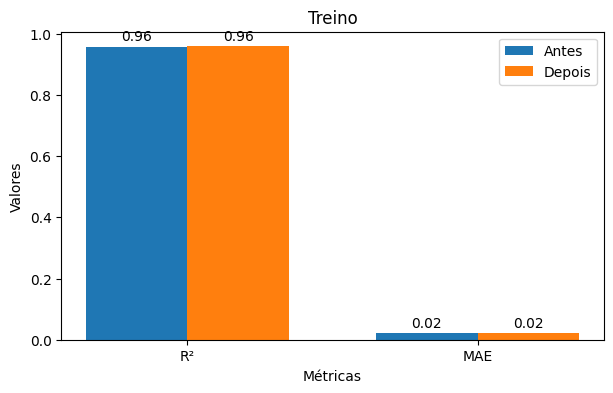

In [31]:
r2 , mae = calculaMetricasTreino(modelRF, x_train, y_train)
r2After , maeAfter = calculaMetricasTreino(modeloRFdepois, x_trainAfter, y_trainAfter)

comparaMetricas(r2, mae, r2After, maeAfter, "Treino")

Aqui podemos observar que não houveram mudanças objetivas nas predições do modelo.

In [32]:
#data_tratado.to_csv('data_tratado_final', index=False)